# Titanic Dataset

This is my spin on the Titanic dataset. I will be using this dataset to show my skills in data analysis and machine learning. The steps I will be taking are as follows:

1. Data acquisition
2. Data cleaning
3. Data exploration and visualization
4. Feature engineering (probably 2, 3 and 4 will be done in parallel)
5. Baseline solutions
6. Modeling
7. Evaluation
8. Conclusion

## Imports

In [5]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from scipy.stats import chi2_contingency, f_oneway, ttest_ind, shapiro
import scipy.stats as ss
import numpy as np
import re

pio.templates.default = "plotly_dark"
pio.renderers.default = "png"

## Loading data

The dataset was downloaded from [Kaggle](https://www.kaggle.com/c/titanic/data) and saved in the `data` folder.

In [6]:
df = pd.read_csv("data/train.csv", engine="pyarrow")
# Normalizing column names
def camel_to_snake(name: str) -> str:
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()
df.columns = [camel_to_snake(col) for col in df.columns]
# Setting PassengerId as index
df = df.set_index("passenger_id")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   name      891 non-null    object 
 3   sex       891 non-null    object 
 4   age       714 non-null    float64
 5   sib_sp    891 non-null    int64  
 6   parch     891 non-null    int64  
 7   ticket    891 non-null    object 
 8   fare      891 non-null    float64
 9   cabin     204 non-null    object 
 10  embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Looking at the data types, there is not much to do at this point. There are, however, many missing values in the `Age`, `Cabin` and `Embarked` columns. I will look at these columns in more detail later to draw conclusions.

Let's take a look at the first few rows of the dataset.	

In [7]:
df.head()

,survived,pclass,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
passenger_id,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


Pretty standard.

## Working with the data

With the dataframe in hand, we can start working with it.  

In no particular order, I'll work the columns of the dataset:

### Sex

The `Sex` column is a categorical column with two possible values: `male` and `female`. Can this explain the survival rate? Let's take a look.

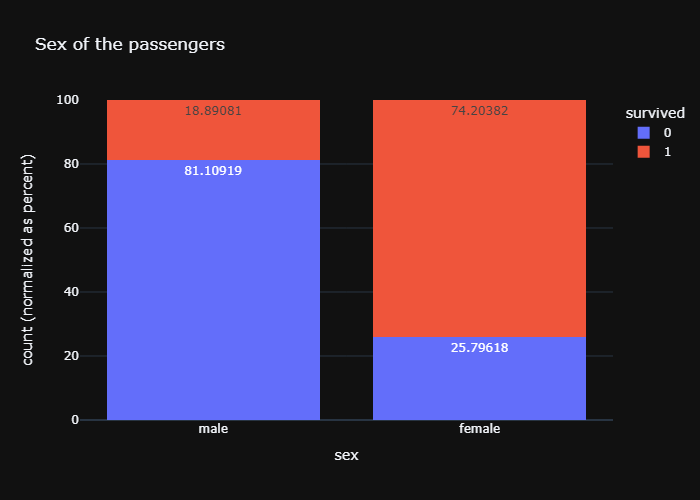

In [8]:
fig = px.histogram(
    df,
    x="sex",
    color="survived",
    text_auto=True,
    title="Sex of the passengers",
    barmode="stack",
    barnorm="percent",
)
fig.show()

In [9]:
probability_survival_sex_df = df.groupby("sex").agg({"survived": "mean"})
female_survival_rate = probability_survival_sex_df.loc["female", "survived"]
male_survival_rate = probability_survival_sex_df.loc["male", "survived"]
survival_rate_difference = (female_survival_rate - male_survival_rate) * 100

print(f"Probability of survival is {survival_rate_difference:.2f}% higher if the passenger is a female")


Probability of survival is 55.31% higher if the passenger is a female


It's clear that female passengers had proportionally higher chances of survival than male passengers. Chivalry is not dead. At least aboard the Titanic it was not.  

Could this be a coincidence? Or is there a statistical significance to this? Let's test it with a chi-square test. The null hypothesis ($H_0$) is that there is no relationship between the `Sex` and `Survived` columns. The alternative hypothesis ($H_1$) is that there is a relationship between the two columns. Let's set the significance level ($\alpha$) to 0.05.

If the p-value is less than $\alpha$, we reject the null hypothesis. Otherwise, we fail to reject the null hypothesis.

In [10]:
alpha = 0.05
contingency_table = pd.crosstab(df['sex'], df['survived'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Rejection criteria: {p_value < alpha}")

Chi-squared statistic: 260.71702016732104
P-value: 1.1973570627755645e-58
Rejection criteria: True


With such a low p-value and a high chi-square statistic, we can reject the null hypothesis and conclude that there is a strong relationship between the `Sex` and `Survived` columns. In other words, the `Sex` can be a good predictor of survival.

### Name

Can the name of the passenger carry any useful information about their survival? Let's take a look at the first few rows of the `Name` column.

In [11]:
df["name"].head(10)

passenger_id
1                               Braund, Mr. Owen Harris
2     Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                Heikkinen, Miss. Laina
4          Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                              Allen, Mr. William Henry
6                                      Moran, Mr. James
7                               McCarthy, Mr. Timothy J
8                        Palsson, Master. Gosta Leonard
9     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
10                  Nasser, Mrs. Nicholas (Adele Achem)
Name: name, dtype: object

Are they completely unique?

In [12]:
df['name'].nunique()

891

I can see some opportunities here. The `Name` column contains the title, family name and wife/husband name. For now, I will extract the title and try to use it.

In [13]:
df["title"] = df["name"].str.extract(r"([A-Za-z]+)\.")
df["title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

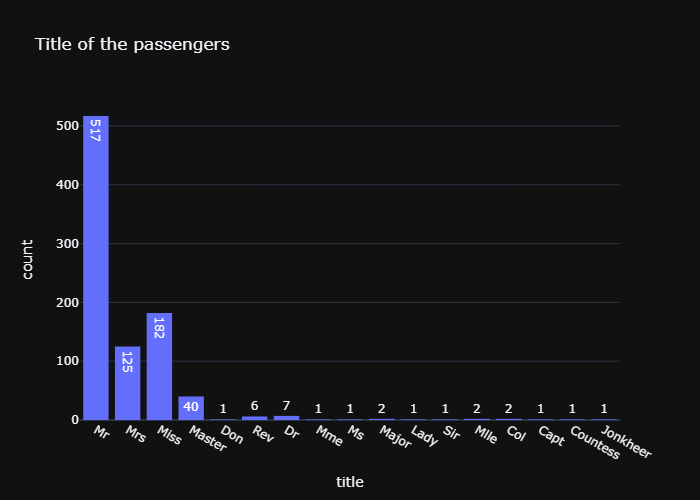

In [14]:
fig = px.histogram(
    df,
    x="title",
    text_auto=True,
    title="Title of the passengers",
)
fig.show()

There are some weird titles in there. Mlle is for Mademoiselle, the French equivalent of Miss. Mme is for Madame, the French equivalent of Mrs. Ms is for Mistress, which is the archaic equivalent of Miss. I will replace these titles with Miss and Mrs, respectively. Jonkheer is a honorific of nobility. And Don is a honorific title used in Spain, Portugal, Brazil and Italy. I will replace these titles with Mr. I will also replace Capt, Col, Major and Dr with Officer. And Rev with Reverend.

More importantly, I will group the titles to avoid subrepresentation of some titles. For example, there is only one Countess, but there are 40 masters.

In [15]:
df["title"].value_counts()

title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

In [16]:
def transform_title(title: str) -> str:
    if title in ["Dr", "Rev", "Major", "Col", "Capt", "Don", "Jonkheer", "Sir"]:
        return "Mr"
    if title in ["Countess", "Lady", "Mme", "Ms"]:
        return "Mrs"
    if title in ["Mlle"]:
        return "Miss"
    return title
df["grouped_title"] = df["title"].apply(transform_title)
df["grouped_title"].value_counts()

grouped_title
Mr        538
Miss      184
Mrs       129
Master     40
Name: count, dtype: int64

Now we can meaningfully plot the survival rate by title.

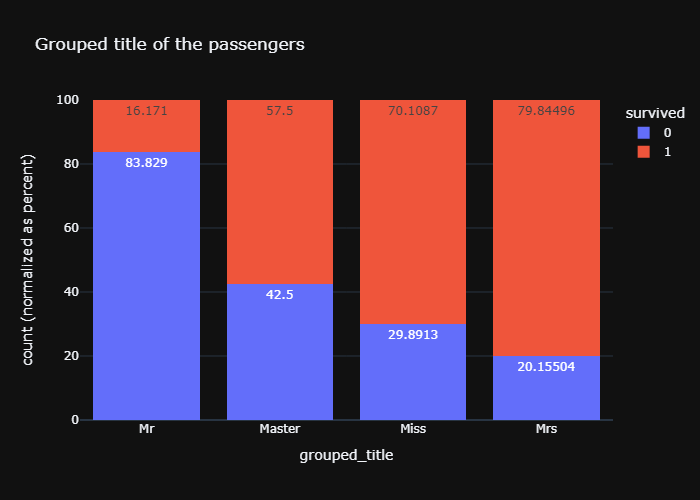

In [17]:
fig = px.histogram(
    df,
    x="grouped_title",
    text_auto=True,
    title="Grouped title of the passengers",
    color="survived",
    barmode="stack",
    barnorm="percent",
)
fig.show()

Again, we can see the sex influence on the survival rate. But we can also see that some titles have a higher survival rate than others. For example, the survival rate of masters is higher than the survival rate of Mr. Why is that? The answer is simple: masters should be children. Let's take a look at the age distribution of masters.

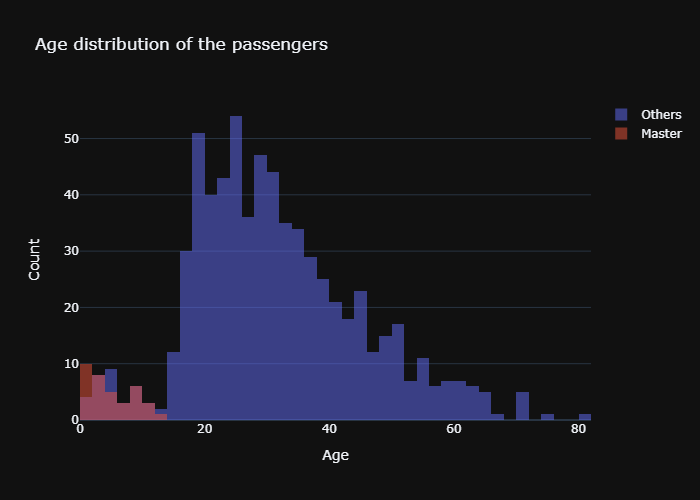

In [18]:
fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=df.query("grouped_title != 'Master'")["age"],
        name="Others",
        opacity=0.50,
    )
)
fig.add_trace(
    go.Histogram(
        x=df.query("grouped_title == 'Master'")["age"],
        name="Master",
        opacity=0.50,
    )
)
fig.update_layout(
    title="Age distribution of the passengers",
    xaxis_title="Age",
    yaxis_title="Count",
    barmode="overlay",
)
fig.show()

It seems that masters are indeed children. Then, it makes sense that they have a high survival rate when compared to Mr.  

But what about statistical significance? Let's test it with a chi-square test. The null hypothesis ($H_0$) is that there is no relationship between the `Title` and `Survived` columns. The alternative hypothesis ($H_1$) is that there is a relationship between the two columns. Let's set the significance level ($\alpha$) to 0.05.

In [19]:
alpha = 0.05
contingency_table = pd.crosstab(df['grouped_title'], df['survived'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Rejection criteria: {p_value < alpha}")

Chi-squared statistic: 290.48495305881914
P-value: 1.1402057054116866e-62
Rejection criteria: True


We can expect that this information will have a high correlation with `Sex`. It should be interesting to see how it will affect the model. Let's take a look at Cramer's V.

In [20]:
contingency_table = pd.crosstab(df['sex'], df['grouped_title'])

# calculate Cramer's V
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
n = contingency_table.sum().sum()
phi2 = chi2/n
r, k = contingency_table.shape
phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
r_corr = r - ((r-1)**2)/(n-1)
k_corr = k - ((k-1)**2)/(n-1)
V = np.sqrt(phi2corr / min((k_corr-1), (r_corr-1)))

# print results
print(f"Cramer's V: {V}")

Cramer's V: 0.9964116041769145


There is a really strong association between these two variables. Maybe it'll be a good idea to drop the `Sex` column and keep the `grouped_title` column.

### Age

Since we started tinkerng with the `Age` column, let's continue. We saw that there are many missing values in this column. Let's take a look at the distribution of the `Age` column.

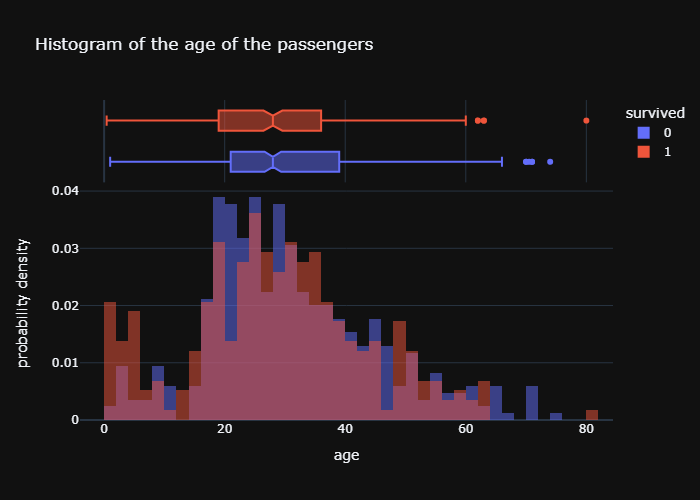

In [21]:
fig = px.histogram(
    df,
    x="age",
    # text_auto=True,
    title="Histogram of the age of the passengers",
    color="survived",
    barmode="overlay",
    histnorm="probability density",
    marginal="box",
)
fig.show()

Formally test for normality.

In [22]:
alpha = 0.05
# Test for normality
import scipy.stats as ss

# perform Shapiro-Wilk test
statistic, p_value = ss.shapiro(df['age'].dropna())

# print results
print(f"Shapiro-Wilk test statistic: {statistic}")
print(f"P-value: {p_value}")
print(f"Rejection criteria: {p_value < alpha}")

Shapiro-Wilk test statistic: 0.981458306312561
P-value: 7.340329943872348e-08
Rejection criteria: True


Well... It's not a normal distribution. So, there were more young people aboard the Titanic than old people. This is not surprising. However, there is not a visually significant difference between the age distribution of the survived and not survived passengers. Let's perform a Mann-Whitney U test. The null hypothesis ($H_0$) is that there is no difference between the `Age` distributions of the survived and not survived passengers. The alternative hypothesis ($H_1$) is that there is a difference between the `Age` distributions of the survived and not survived passengers. Let's set the significance level ($\alpha$) to 0.05.

In [23]:
alpha = 0.05
# create groups based on the categorical variable
survived = df[df['survived'] == 0]['age'].dropna()
not_survived = df[df['survived'] == 1]['age'].dropna()

# perform Mann-Whitney U test
statistic, p_value = ss.mannwhitneyu(survived, not_survived)

# print results
print(f"Mann-Whitney U test statistic: {statistic}")
print(f"P-value: {p_value}")
print(f"Rejection criteria: {p_value < alpha}")

Mann-Whitney U test statistic: 65278.0
P-value: 0.16049252477737763
Rejection criteria: False


In [24]:
print(f"Mean age of survived passengers: {survived.mean():.2f}")
print(f"Mean age of not survived passengers: {not_survived.mean():.2f}")

Mean age of survived passengers: 30.63
Mean age of not survived passengers: 28.34


We cannot reject the null hypothesis. There is no difference between the `Age` distributions of the survived and not survived passengers. Well... It's not very surprising. However, we should see if this variable shares any correlation with another variable. 

In [25]:
df.corr(numeric_only=True)["age"].sort_values(ascending=False, key=lambda x: abs(x))[1:]

pclass     -0.369226
sib_sp     -0.308247
parch      -0.189119
fare        0.096067
survived   -0.077221
Name: age, dtype: float64

I will mantain this variable in hope that it has some interaction with another variable during the modeling phase. But, what if I bin this variable? Let's take a look at the distribution of the `Age` column with fewer bins.

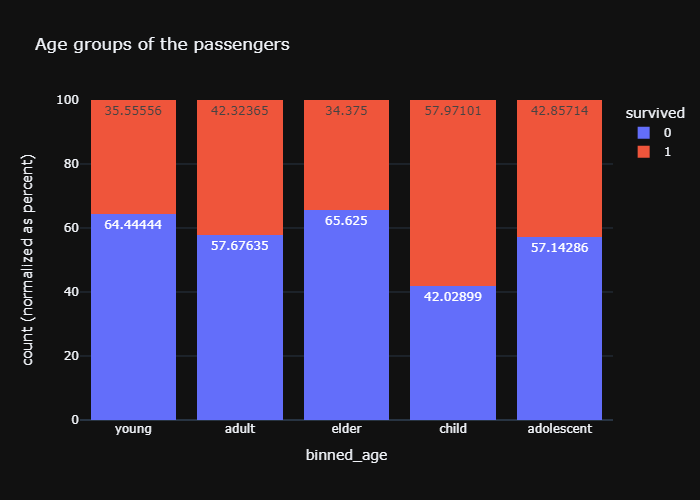

In [26]:
df["binned_age"] = pd.cut(df["age"], bins=[0, 12, 18, 30, 50, 100], labels=["child", "adolescent","young", "adult", "elder"])

fig = px.histogram(
    df,
    x="binned_age",
    text_auto=True,
    title="Age groups of the passengers",
    color="survived",
    barmode="stack",
    barnorm="percent",
)
fig.show()

In [27]:
alpha = 0.05
contingency_table = pd.crosstab(df['binned_age'], df['survived'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Rejection criteria: {p_value < alpha}")

Chi-squared statistic: 12.953825242535116
P-value: 0.011503629719229361
Rejection criteria: True


By binning the numeric variable we could help it to better explain the target variable. This is also better seen at the histogram. But, in the end, depending on the model, it may not be necessary to bin the variable. Tree-based models, for example, may automatically find the best split points for the variable. But from an analysis point of view, it is interesting to be able to better see the relationship between the variable and the target variable.

### Pclass

Pclass is the passenger class. It is a categorical variable with three possible values: 1, 2 and 3. Class 1 is the highest class and class 3 is the lowest class. This is an interesting variable because it can be a proxy for the passenger's wealth. Also, it can be deal with both as a categorical variable and as a numeric variable (keeping in mind that this is a discrete numeric variable). Let's take a look at the distribution of the `Pclass` column.

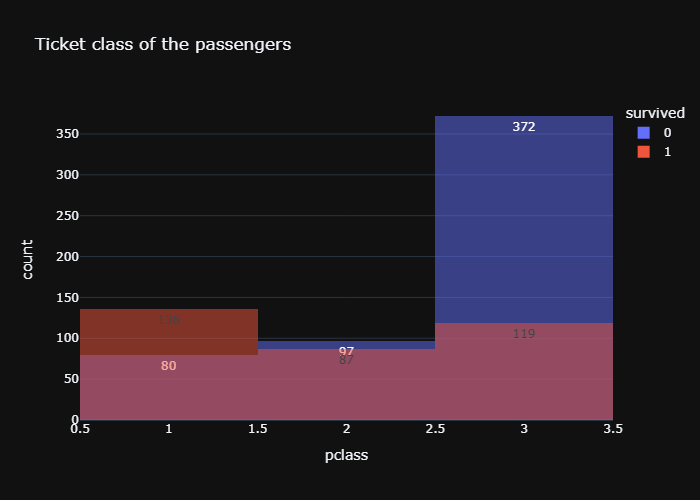

In [28]:
fig = px.histogram(
    df,
    x="pclass",
    text_auto=True,
    title="Ticket class of the passengers",
    color="survived",
    barmode="overlay",
)
fig.show()

Let's take a look at the survival rate by `Pclass`.

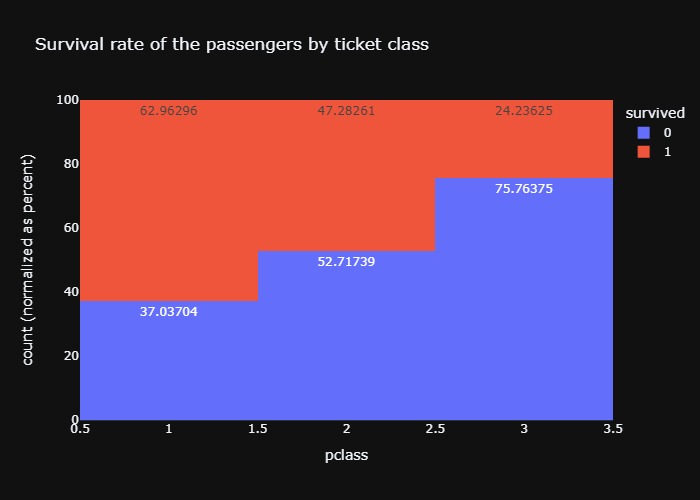

In [29]:
fig = px.histogram(
    df,
    x="pclass",
    text_auto=True,
    title="Survival rate of the passengers by ticket class",
    color="survived",
    barmode="stack",
    barnorm="percent",
)
fig.show()

We see that upper class passengers had the highest survival rates. With a quick search, I came accross some explanations to this: they had easier access to lifeboats, which were located on the upper decks and they had more infuence. Simple as that. Let's test this hypothesis. The null hypothesis ($H_0$) is that there is no relationship between the `Pclass` and `Survived` columns. The alternative hypothesis ($H_1$) is that there is a relationship between the two columns. Let's set the significance level ($\alpha$) to 0.05.

In [30]:
alpha = 0.05
contingency_table = pd.crosstab(df['pclass'], df['survived'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Rejection criteria: {p_value < alpha}")

Chi-squared statistic: 102.88898875696056
P-value: 4.549251711298793e-23
Rejection criteria: True


As seen before, there is a strong relationship between the pclass variable and the target. We can say that the pclass variable is a good predictor of survival.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   survived       891 non-null    int64   
 1   pclass         891 non-null    int64   
 2   name           891 non-null    object  
 3   sex            891 non-null    object  
 4   age            714 non-null    float64 
 5   sib_sp         891 non-null    int64   
 6   parch          891 non-null    int64   
 7   ticket         891 non-null    object  
 8   fare           891 non-null    float64 
 9   cabin          204 non-null    object  
 10  embarked       889 non-null    object  
 11  title          891 non-null    object  
 12  grouped_title  891 non-null    object  
 13  binned_age     714 non-null    category
dtypes: category(1), float64(2), int64(4), object(7)
memory usage: 98.5+ KB
